# Localized 1D solutions in phase-field approach to brittle fracture {far}`star`{far}`star`

```{admonition} Objectives
:class: objectives

This demo demonstrates how to solve a bound-constrained PDE optimization problem using `PETSc TAO` solver. The application examples involves the computation of localized solutions in the phase-field/damage gradient approach to brittle fracture.
$\newcommand{\dOm}{\,\text{d}\Omega}$
```

```{admonition} Download sources
:class: download

* {Download}`Python script<./bound_constrained.py>`
* {Download}`Jupyter notebook<./bound_constrained.ipynb>`
* {Download}`Complete sources files<./bound_constrained.zip>`
```

## Introduction

Bound-constrained problems involve finding the optimal solution of optimization problems of the form:

```{math}
\begin{array}{rl} \displaystyle{\min_{x\in\mathbb{R}^n}} & f(x)\\
\text{s.t.} & x_l \leq x \leq x_u
\end{array}
```

where $f(x)$ is the objective function to minimize and $x_l, x_u$ are known lower and upper bounds set on the optimization vector $x$.

There exist many methods to solve such a constrained optimization problem. It is important to note that constraints are here very simple as they bound only the minimum and maximum values of the optimization variable $x$. In particular, this setting does not allow for more general linear or non-linear equality or inequality constraints.

PETSc's [Toolkit for Advanced Optimization (TAO)](https://petsc.org/main/manual/tao/#) offers a wide range of algorithms to solve various constrained or unconstrained optimization problems, including bound-constrained problems. To interact with such a solver, the user is required to provide the objective function and the bounds. Depending on the chosen algorithm, the user should also provide:
* the objective gradient $\nabla f(x)$;
* the Hessian operator $\nabla^2 f(x)$.

In the following demo, we will use

## Problem position

We consider a simple 1D bound constrained problem which arise from the use of *phase-field* or *damage gradient* models of brittle fracture {cite:p}`bourdin2000numerical,pham2011gradient`. In such methods, we simulate the propagation of cracks by minimizing a total energy consisting of an elastic and a fracture energy. When using one of the classical models of the phase-field approach, namely the $\text{AT1}$ model, the fracture energy is written as:
```{math}
:label: AT1-Efra

\mathcal{E}_\text{f}(d) = \dfrac{3G_\text{c}}{8\ell_0}\int_{\Omega}\left(d + \ell_0^2\nabla d \cdot\nabla d\right)\dOm
```
where $d$ is a damage-like variable (with values in $[0;1]$) which smears the discrete crack representation (corresponding to $d=1$) over a regularization length $\ell_0$. $G_\text{c}$ represents the material fracture energy.

During the solution process, the damage field is found by minimizing the total energy for a fixed displacement field and subject to bound constraints $d_n \leq d \leq 1$ where $d_n$ denotes the damage field at the previous time step which is used to enforce the irreversible evolution of damage.

When subject to a given mechanical loading, damage field will tend to localize spatially, corresponding to a smeared crack representation. In the 1D setting, it is possible to characterize the shape of the localized solution by finding damage fields which minimize the fracture energy {eq}`AT1-Efra`.

## Localized 1D solutions

More precisely, we consider a 1D domain $\Omega=[-L;L]$ of length $2L$ and we look for a minimizer $d(x)$ of:

```{math}
:label: AT1-Efra-1D

\begin{array}{rl} \displaystyle\min_{d(x)} & \displaystyle\int_{\Omega}\left(d + \ell_0^2\left(\dfrac{\partial d}{\partial x}\right)^2\right)\dOm \\
\text{s.t.} & 0 \leq d(x) \leq 1 \quad \forall x \in \Omega
\end{array}
```

where we ignored the factor $3G_\text{c}/(8\ell_0)$ of the fracture energy. In the following, we note $j(d)$ the objective function of {eq}`AT1-Efra-1D`.

In addition, in order to force localization around a given point, we will impose here the boundary condition $d(x)=d_0$ at $x=0$ where $d_0\in [0;1]$ is given. In this case, we can show that there exists a region $]-D;D[$ where $0 < d(x) < 1$ and with $d(x)=0$ outside. We can show in particular that we must have $d(\pm D) = \dfrac{\partial d}{\partial x}(\pm D) = 0$ at the transition points {cite:p}`pham2011gradient,pham2013onset`.

In the inner region, since the bounds are not attained, the optimal solution is characterized by the fact that the first variation of the objective is null, that is:
\begin{align*}
D_d j(d;\widehat{d}) = 0 \quad \forall \widehat{d}\\
\int_{\Omega} \left(\widehat{d} + \ell_0^2 \dfrac{\partial d}{\partial x}\dfrac{\partial \widehat{d}}{\partial x}\right)\dOm = 0 \quad \forall \widehat{d}\\
\end{align*}

The corresponding linear variational problem results in the following strong form differential equation:

$$
\dfrac{\partial^2 d}{\partial x^2} = \dfrac{1}{2\ell_0^2}
$$

Accounting for the following boundary conditions:

$$
d(0)=d_0 \quad ; \quad d(\pm D) = 0 \quad ;\quad  \dfrac{\partial d}{\partial x}(\pm D) = 0
$$

we easily show that the localization region size is $D=2\ell_0\sqrt{d_0}$ and that the solution is given by:

```{math}
:label: AT1-1D-solution

d(x) = \begin{cases}
\left(\sqrt{d_0} - \dfrac{|x|}{2\ell_0}\right)^2 & \text{if } |x| \leq D \\
0 & \text{otherwise}
\end{cases}
```

## Implementation

For the implementation, we first provide a utility class `TAOProblem` in the {download}`tao_problem.py` module. This class enables to interact with PETSc TAO solver objects by providing methods for computing the objective function, the gradient and the Hessian/Jacobian of the objective.

We now import the relevant modules and define the 1D domain $\Omega=[-L;L]$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from petsc4py import PETSc
from mpi4py import MPI
import ufl
from dolfinx import fem, mesh
import dolfinx.fem.petsc
from tao_problem import TAOProblem

N = 40
L = 5.0
domain = mesh.create_interval(MPI.COMM_WORLD, 2 * N, [-L, L])

We now create a scalar $\mathbb{P}_1$ Lagrange function space and defines functions to store the lower and upper bound values.

In [2]:
V = fem.functionspace(domain, ("P", 1))
d = fem.Function(V)
d_ = ufl.TestFunction(V)
dd = ufl.TrialFunction(V)
dlb = fem.Function(V, name="Lower_bound")
dlb.vector.set(0.0)
dub = fem.Function(V, name="Upper_bound")
dub.vector.set(1.0)

We define the boundary condition at $x=0$.

In [3]:
def middle_node(x):
    return np.isclose(x[0], 0)


middle_dof = fem.locate_dofs_geometrical(V, middle_node)

d_imp = fem.Constant(domain, 0.0)
bcs = [fem.dirichletbc(d_imp, middle_dof, V)]

We now define the objective function to minimize, corresponding to the fracture energy up to a scaling factor. We also use `ufl.derivative` to compute automatically the first and second variations which will be used for setting the gradient and Hessian.

In [4]:
ell0 = fem.Constant(domain, 1.0)
energy = (d + ell0**2 * ufl.dot(ufl.grad(d), ufl.grad(d))) * ufl.dx
D_energy = ufl.derivative(energy, d, d_)
D2_energy = ufl.derivative(D_energy, d, dd)

Now, we instantiate the `TAOProblem` object by providing the objective function form and its first and second variations, the function `d` corresponding to the optimization variable and the associated boundary condition list.

In [5]:
problem = TAOProblem(energy, D_energy, D2_energy, d, bcs)

We now setup the TAO solver object using `petsc4py`. We use a Bounded Newton Line Search `bnls` method and use a direct LU solver for the resolution of linear systems arising in the underlying Newton method.

```{seealso}
For more details on the algorithm and other available solvers, see the [bound-constrained solvers documentation](https://petsc.org/main/manual/tao/#bound-constrained-optimization).
```

In [6]:
tao = PETSc.TAO().create(PETSc.COMM_SELF)
tao.setType("bnls")
tao.getKSP().setType("preonly")
tao.getKSP().getPC().setType("lu")

We use the utility functions provided by the `TAOProblem` class to set the objective, the gradient and the Hessian.

In [7]:
tao.setObjective(problem.f)
tao.setGradient(problem.F, problem.b)
tao.setHessian(problem.J, problem.A)

Finally, we set the corresponding variable bounds and we also prescribe some stopping tolerances where:

\begin{align*}
\texttt{gatol} &= \|\nabla f(X)\|\\
\texttt{grtol} &= \|\nabla f(X)\|/|f(X)|\\
\texttt{gttol} &= \|\nabla f(X)\|/ \|\nabla f(X_0)\|
\end{align*}
with $X_0$ being the initial value.

In [8]:
tao.setVariableBounds(dlb.vector, dub.vector)
tao.setTolerances(gatol=1e-6, grtol=1e-6, gttol=1e-6)

We now set different values of $d_0 \in [0;1]$ and solve the corresponding problem.

Fished solving 0.0
Fished solving 0.23908482142857146
Fished solving 0.6754335937500002
Fished solving 1.2403515625000001
Fished solving 1.9092606026785717
Fished solving 2.66796875


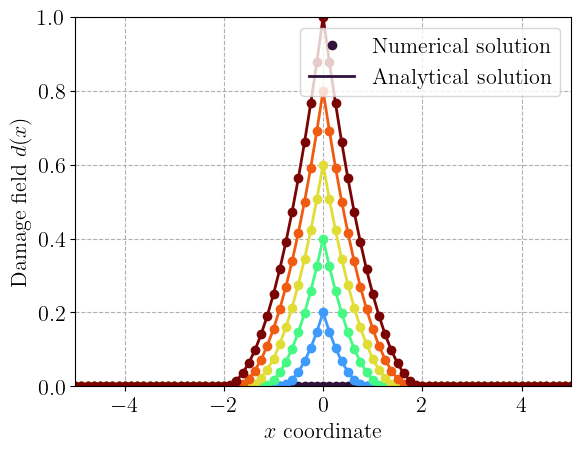

In [9]:
values = np.linspace(0, 1.0, 6)
x = V.tabulate_dof_coordinates()[:, 0]
plt.figure()
plt.gca().set_prop_cycle(color=plt.cm.turbo(values))
for d0 in values:
    d_imp.value = d0
    fem.set_bc(d.vector, bcs)

    tao.solve(d.vector)
    dvals = d.vector.array

    h = plt.plot(x, dvals, "o")
    l0 = ell0.value
    ppos = lambda x: np.maximum(x, np.zeros_like(x))
    d_an = (ppos(np.sqrt(d0) - np.abs(x / 2 / l0))) ** 2
    plt.plot(x, d_an, "-", color=h[0].get_color())

plt.ylim(0, 1.0)
plt.xlim(-L, L)
plt.xlabel(r"$x$ coordinate")
plt.ylabel(r"Damage field $d(x)$")
plt.legend(("Numerical solution", "Analytical solution"))
plt.show()


tao.destroy()

```{bibliography}
:filter: docname in docnames
```